In [1]:
#Created on Mon July 22 16:03:30 2020
#@author: SYunMoon

import cv2 
import numpy as np 
from matplotlib import pyplot as plt
import os
import time

In [30]:
###  create empty list to store images.
data = []

directory = ('64x64\color')

for i in os.listdir(directory)[0:100]:
    image = cv2.imread(os.path.join(directory,i)).astype('float64')
    data.append(image)  


In [31]:
len(data)

100

In [32]:
### Calculate brightness of a pixel.  

def brightness (pixel):
    
    brightness = np.sqrt(np.sum(np.square(pixel)))
    
    return brightness

In [33]:
### calculate color distortion. 
### vi is (R,G,B) of a codeword and img is (R,G,B) of the pixel.

def colordist (vi, img):
    
    cdist = np.sqrt(np.sum(np.square(img)) - (np.square(np.sum(vi*img)))/np.sum((np.square(vi))))
    
    return cdist.astype('float64')

In [34]:
# =============================================================================
# codeword_update : update codeword when there is matching codeword.
# parameters  
#          codeword : old codeword to be updated 
#          img : (R,G,B) of the pixel 
#          number_of_training : frame number.  
# =============================================================================

def codeword_update (codeword,img,number_of_training):
    
    codeword[5] = codeword[5]+1.0
    codeword[0] =  (codeword[5] * codeword[0] + img[0])/(codeword[5]+1)
    codeword[1] =  (codeword[5] * codeword[1] + img[1])/(codeword[5]+1)
    codeword[2] =  (codeword[5] * codeword[2] + img[2])/(codeword[5]+1)
    codeword[3] = np.minimum(codeword[3], brightness(img))
    codeword[4] = np.maximum(codeword[4], brightness(img))
    codeword[6] = np.maximum(codeword[6], number_of_training - codeword[8])
    codeword[8] = number_of_training
     
    return codeword

In [35]:
start = time.time()

### an empty list to store codewords (codebook). 
all_vi = []

### dimension of images
height  = len(data[0])
width = len(data[0][0])

### range of alpha and beta from paper.
### alpha = 0.4 ~ 0.7, beta = 1.1 ~ 1.5 
alpha = 0.45
beta = 1.2

### sampling threshold from paper.
sampling_th = 3.0

for i in range(height):
    all_vi.append([])
    for j in range(width):
        all_vi[i].append([])

        c = 0
        ### initial codeword for a pixel(i,j)
        vi = [[data[0][i][j][0],data[0][i][j][1],data[0][i][j][2],brightness(data[0][i][j][:]),
               brightness(data[0][i][j][:]),1,0,c,c]]
        
        ### loop over all frames.
        for z in range (len(data)):
            
            length = len(vi)
            
            ### brightness of (i,j) in zth frame.
            I = brightness(data[z][i][j][:])
            
            ### loop over codewords
            for k in range (length):
                updated = False
                
                ### brightness of the codeword.
                Ilow = alpha * vi [k][4]   
                Ihi = np.minimum(beta * vi[k][4], vi[k][3]/alpha)
                
                ### if there is a matching codeword, update the codeword. 
                if colordist(np.array(vi[k][0:3]),data[z][i][j][:]) <= sampling_th and Ilow <= I <= Ihi:
                    
                    vi.insert(0,vi.pop(k))
                    updated = True
                    break
                    
            ### if there is no matching codeword, create a new codeword. 
            ### to save the calculation time, put the new codeword in the first row. 
            if updated==False:
                vi.insert(0,[data[z][i][j][0],data[z][i][j][1],data[z][i][j][2],I, I,1,c,c,c])
            c = c+1
        ### store all the codewords in a coddbook.     
        all_vi[i][j].append(vi) 
        
end = time.time()
elapsed_time = end - start
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:00:23'

In [36]:
### threshold for MNRL (Maximum Negative Run-Length)
threshold = len(data)/2

### remove codewords that have MNRL > threshold.
remove= []

for i in range (height):
    remove.append([])
    for j in range (width):
        remove[i].append([])
        
        length = len(all_vi[i][j][0][:])
        
        for k in range (length):
            if all_vi[i][j][0][k][6] <threshold:
                remove[i][j].append(all_vi[i][j][0][k])

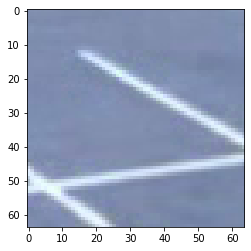

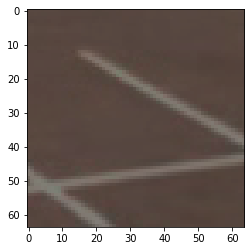

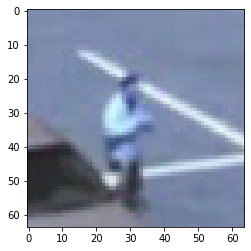

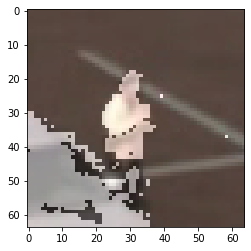

In [37]:
### detection threshold for color distortion.
detection_th = 9

### show the result of the image segmentation.
### the function returns input image (uint8) and overlay image. 
def test_image(image):
    mask = np.ones((height,width),dtype = int)*255

    image = image / np.max(image) * 255
    for i in range (height):
        for j in range (width):
            
            I = brightness(image[i,j,:]) 
            length = len(remove[i][j][:])
            
            for k in range (length):
                Ilow = alpha * remove[i][j][k][4]
                Ihi = np.minimum(beta * remove[i][j][k][4], remove[i][j][k][3]/alpha)
                
                ### if the color distortion and the brightness is in the codeword, that pixel is classified as a background. 
                if colordist(np.array(remove[i][j][k][0:3]),image[i,j,:]) <= detection_th and Ilow <= I <= Ihi:
                    mask[i,j] = 0
                    
                    break
                    
    mask3d = cv2.merge([mask,mask,mask])
    image = image.astype(np.uint8)
    mask3d = mask3d.astype(np.uint8)
    RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    added_image = cv2.addWeighted(RGB_im,0.5,mask3d,0.5,0)
    
    return added_image,image

result1, image1 = test_image (image = data[50][:][:][:])
result2, image2 = test_image (image = data[75][:][:][:])

plt.figure(1)
plt.imshow(image1)
plt.figure(2)
plt.imshow(result1)
plt.figure(3)
plt.imshow(image2)
plt.figure(4)
plt.imshow(result2)
plt.show()